# NB-HI7: Long-term dryness index changes for early, mid and late 21st century periods from historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'

np.seterr(divide='ignore', invalid='ignore')


The Python version: 3.7.0
xarray 0.16.2


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change

Last executed: 2021-08-05 10:32:54.327391 by mizukami on crhtc46


### dask jobque setup

In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [6]:
figSave = True

In [7]:
gcms        = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
pet_vars    = ['PRCP', 'OUT_PET_NATVEG']
period_hist = slice('1970-01-01', '1999-12-31')
period_futr = {'early' : slice('2010-01-01', '2039-12-31'),
               'middle': slice('2040-01-01', '2069-12-31'),
               'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [8]:
xr.set_options(file_cache_maxsize=12000)

histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=pet_vars, region='HI', parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=pet_vars, region='HI', parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=pet_vars, region='HI', parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [01:59<00:00, 11.93s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [03:30<00:00, 21.02s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [03:41<00:00, 22.14s/it]


## Compute 30-yr annual mean PCP and PET for 4 periods - historical, early, mid and late

In [9]:
%%time
histo_ann = resample_data(histo_data['gcm'].sel(time=period_hist), region='HI', freq='AS').mean('time').compute()

rcp45_ann = {}
rcp85_ann = {}
for key, futr_period in period_futr.items():
    rcp45_ann[key] = resample_data(rcp45_data.sel(time=futr_period), region='HI', freq='AS').mean('time').compute()
    rcp85_ann[key] = resample_data(rcp85_data.sel(time=futr_period), region='HI', freq='AS').mean('time').compute()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

CPU times: user 1min 16s, sys: 2min 28s, total: 3min 45s
Wall time: 8min 4s


## Additional process - compute dryness index, and cleanup

In [10]:
# compute dryness
histo_ann['dryness'] = histo_ann['OUT_PET_NATVEG']/histo_ann['PRCP']
for key, futr_period in period_futr.items():
    rcp45_ann[key]['dryness'] = rcp45_ann[key]['OUT_PET_NATVEG']/rcp45_ann[key]['PRCP']
    rcp85_ann[key]['dryness'] = rcp85_ann[key]['OUT_PET_NATVEG']/rcp85_ann[key]['PRCP']

## Compute difference in 30-yr annual mean between historical and future

In [11]:
rcp45_ann_30yr_diff = {}
rcp85_ann_30yr_diff = {}
diff_rcp_ann_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_ann_30yr_diff[key] = calc_change(histo_ann, rcp45_ann[key], pct=False).persist()
    rcp85_ann_30yr_diff[key] = calc_change(histo_ann, rcp85_ann[key], pct=False).persist()
    
    diff_rcp_ann_30yr_change[key] =rcp85_ann_30yr_diff[key] - rcp45_ann_30yr_diff[key]

## Plotting

In [49]:
# create colormap
# ---------------

from matplotlib.colors import LinearSegmentedColormap

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

cmap_change_dry = LinearSegmentedColormap.from_list('custom2', 
                                             [(0,    'xkcd:blue'),
                                              (0.3,  'xkcd:light grey'),
                                              (1,    'xkcd:red')], N=256)

------------
 - Change in 30yr mean between historical and three future periods in 21st century (early, mid, and late) 

In [54]:
# some local plot setups

cm = {'history'    : cmap,
      'history_dry': cmap_change_dry,
      'change'     : custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'change_dry' : custom_div_cmap(numcolors=255, mincol='xkcd:blue', midcol='xkcd:light grey', maxcol='xkcd:red'),
      }

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'flux':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
             'regular': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'flux':    {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['flux']},
                'regular': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['regular']}}

kwargs = {'change_PRCP':           {'levels': 9,  'vmin':-100, 'vmax':100,  'cmap':cm['change'],      'extend':'both', **style_kwargs['regular']},
          'change_OUT_PET_NATVEG': {'levels': 9,  'vmin':-100, 'vmax':100,  'cmap':cm['change'],      'extend':'both', **style_kwargs['regular']},
          'change_dryness':        {'levels': 11, 'vmin':-0.5, 'vmax':0.5,  'cmap':cm['change_dry'],  'extend':'both', **style_kwargs['regular']},
          'PRCP':                  {'levels': 9,  'vmin':0,    'vmax':4000, 'cmap':cm['history'],     'extend':'max',  **style_kwargs['flux']},
          'OUT_PET_NATVEG':        {'levels': 9,  'vmin':0,    'vmax':2000, 'cmap':cm['history'],     'extend':'max',  **style_kwargs['flux']},
          'dryness':               {'levels': 11, 'vmin':0,    'vmax':2.5,  'cmap':cm['history_dry'], 'extend':'max',  **style_kwargs['regular']},
         }

var_title = {'PRCP':'precipitation', 'OUT_PET_NATVEG':'potential evaporation', 'dryness':'dryness index'}
var_unit  = {'PRCP':'mm/yr', 'OUT_PET_NATVEG':'mm/yr', 'dryness':'-'}

In [1]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8.125,8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['PRCP', 'OUT_PET_NATVEG', 'dryness']):
    histo_ann.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_ann_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[f'change_{var}'])
    rcp85_ann_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change_{var}'])
    
    add_ylabel(axes[0, 0], 'historical', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099', fontsize=11)
    axes[0, col].set_title('%s [%s]'%(var_title[var], var_unit[var]), fontsize=12)
    
if figSave:
    plt.savefig(f'NB-HI7_Fig1_annual_mean_change_pet_mid_late_rcp85.png', dpi=300)

NameError: name 'plt' is not defined

------------
 - Difference between two RCPs in 30yr mean change for late 21st century

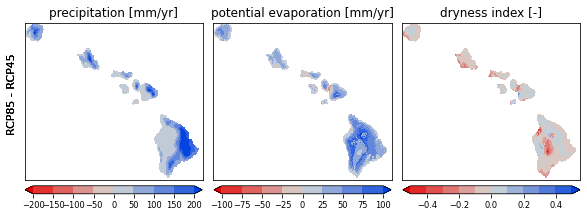

In [60]:
cm = {'change' : custom_div_cmap(numcolors=256, mincol='xkcd:blue', midcol='xkcd:light grey', maxcol='xkcd:red')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}
kwargs       = {'change-rcp': {'levels':21,'vmin':-2, 'vmax':2,  'cmap':cm['change'], 'extend':'both', **style_kwargs}}

cm = {'change' : custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}

kwargs       = {'change-rcp_PRCP':           {'levels':9, 'vmin':-200, 'vmax':200,  'cmap':cm['change'], 'extend':'both', **style_kwargs},
                'change-rcp_OUT_PET_NATVEG': {'levels':9, 'vmin':-100, 'vmax':100,  'cmap':cm['change'], 'extend':'both', **style_kwargs},
                'change-rcp_dryness':        {'levels':11, 'vmin':-0.5, 'vmax':0.5,  'cmap':cm['change'], 'extend':'both', **style_kwargs},
               }

var_title = {'PRCP':'precipitation', 'OUT_PET_NATVEG':'potential evaporation', 'dryness':'dryness index'}
var_unit  = {'PRCP':'mm/yr', 'OUT_PET_NATVEG':'mm/yr', 'dryness':'-'}

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8.125, 3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)

for col, var in enumerate(['PRCP', 'OUT_PET_NATVEG', 'dryness']):
    diff_rcp_ann_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[col], **kwargs[f'change-rcp_{var}'])
    
    add_ylabel(axes[0], 'RCP85 - RCP45', fontsize=11)
    axes[col].set_title('%s [%s]'%(var_title[var], var_unit[var]), fontsize=12)
    
if figSave:
    plt.savefig(f'NB-HI7_Fig2_annual_mean_pet_late_diff_rcp.png', dpi=300)

--------
- annual PET change for individual GCMs for late 21st century are plotted below

--------------------
### PET

#### rcp45

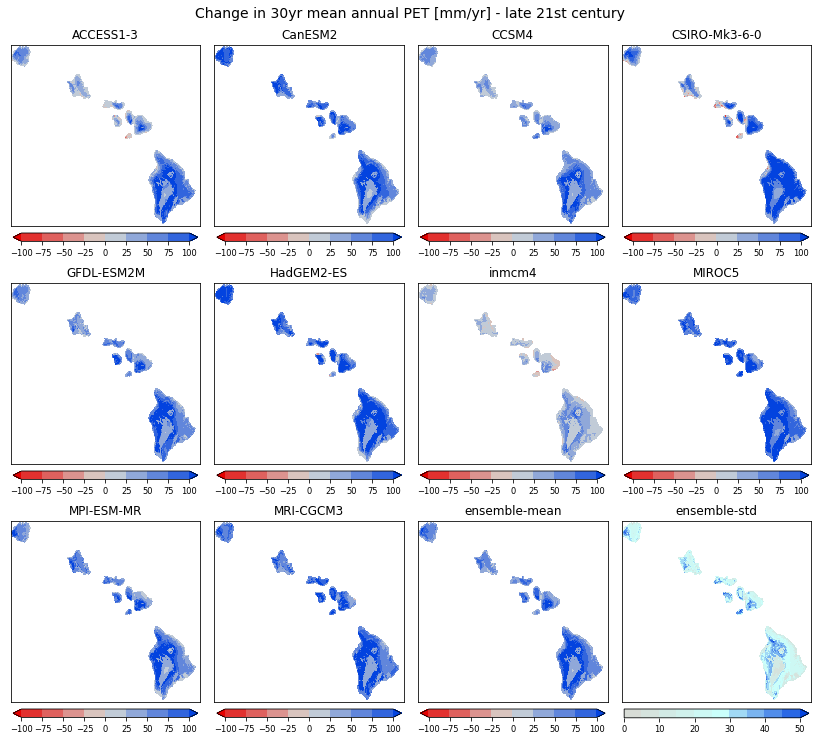

In [61]:
var="OUT_PET_NATVEG"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}

kwargs = {'mean': {'levels': 9, 'vmin':-100, 'vmax':100, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0,    'vmax':50, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_ann_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_ann_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_ann_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual PET [mm/yr] - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI7_Fig3_annual_mean_change_late_{var}_rcp45.png', dpi=300)

#### rcp85

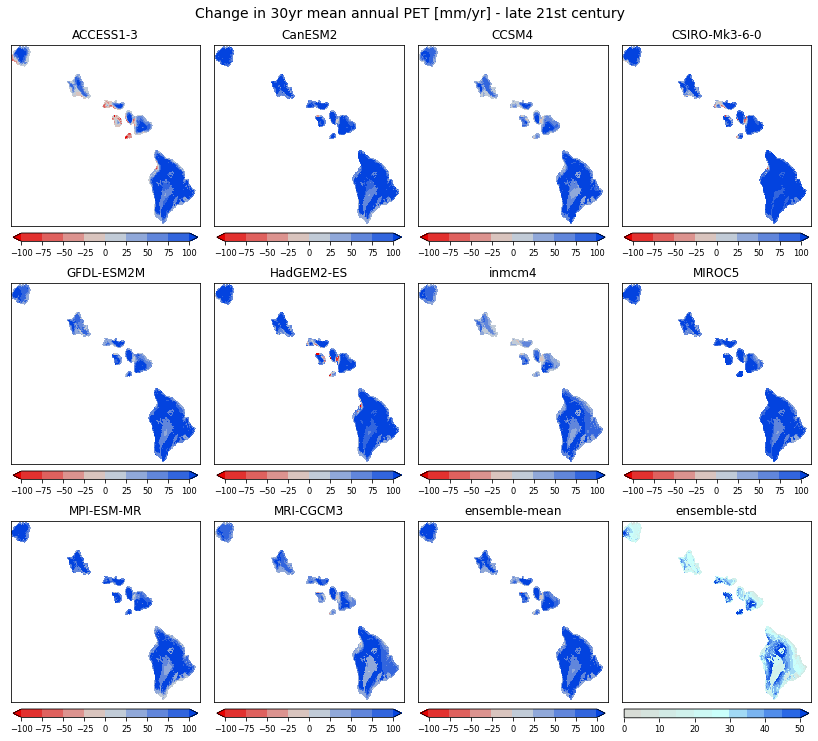

In [63]:
var="OUT_PET_NATVEG"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}

kwargs = {'mean': {'levels': 9, 'vmin':-100, 'vmax':100, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0,    'vmax':50, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_ann_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_ann_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_ann_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual PET [mm/yr] - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI7_Fig4_annual_mean_change_late_{var}_rcp85.png', dpi=300)

------------
 - Change in 30yr seasonal temperature between historical and three future periods in 21st century (early, mid, and late) 

--------------------
### Dryness

#### rcp45

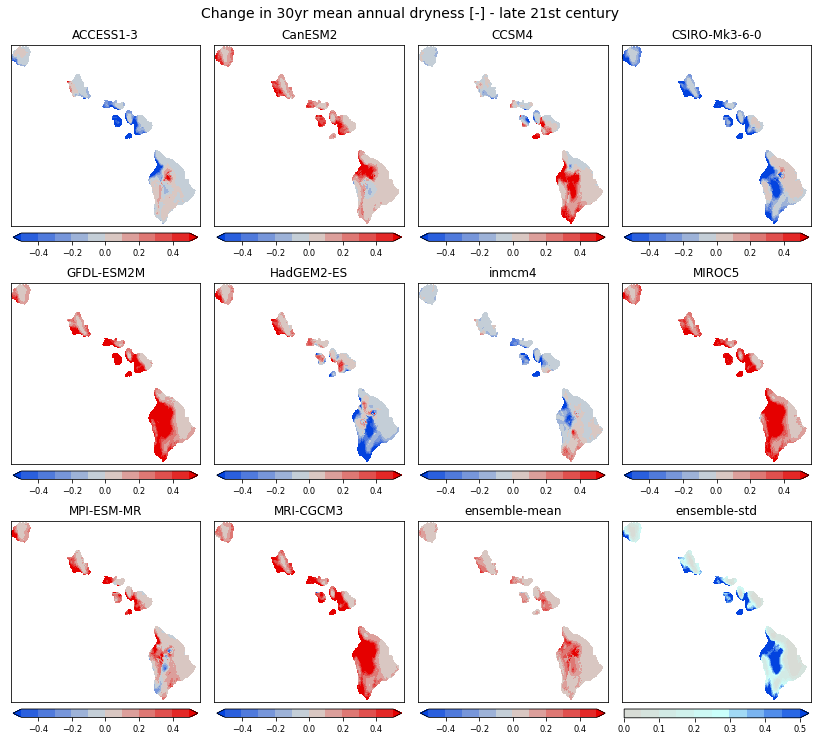

In [70]:
var="dryness"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:blue', midcol='xkcd:light grey', maxcol='xkcd:red'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}

kwargs = {'mean': {'levels': 11, 'vmin':-0.5, 'vmax':0.5, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0,    'vmax':0.5, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_ann_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_ann_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_ann_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual dryness [-] - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI7_Fig5_annual_mean_change_late_{var}_rcp45.png', dpi=300)

#### rcp85

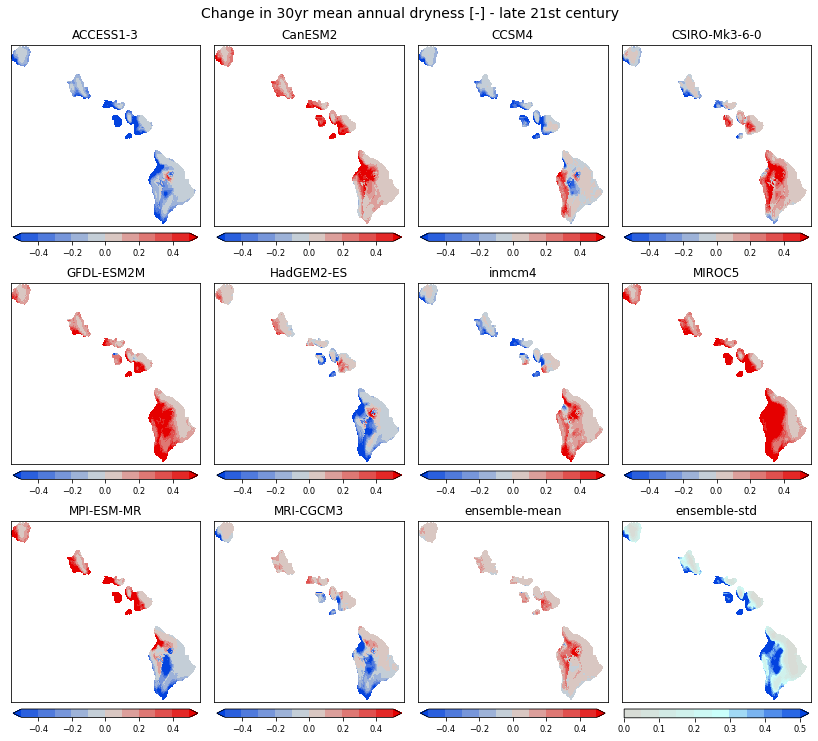

In [69]:
var="dryness"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:blue', midcol='xkcd:light grey', maxcol='xkcd:red'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}

kwargs = {'mean': {'levels': 11, 'vmin':-0.5, 'vmax':0.5, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0,    'vmax':0.5, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_ann_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_ann_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_ann_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual dryness [-] - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI7_Fig6_annual_mean_change_late_{var}_rcp45.png', dpi=300)

In [ ]:
6.5*1.8

In [ ]:
6*1.8

In [ ]:
8.125/3*2